In [19]:
#Pyspark Installation
!pip install pyspark

In [20]:
# We initially import the packages
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
# 1.Creating a SparkSession for Chicago crime dataset
spark = SparkSession.builder.appName("Chicago Crime Data Analysis").getOrCreate()

In [21]:
# 2. Setting up the columns for the Chicago crime data
schema = StructType([
    StructField("ID", StringType(), True),
    StructField("Case Number", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary Type", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location Description", StringType(), True),
    StructField("Arrest", StringType(), True),
    StructField("Domestic", StringType(), True),
    StructField("Beat", StringType(), True),
    StructField("District", StringType(), True),
    StructField("Ward", StringType(), True),
    StructField("Community Area", StringType(), True),
    StructField("FBI Code", StringType(), True),
    StructField("X Coordinate", StringType(), True),
    StructField("Y Coordinate", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True)
])


In [23]:
# Importing packages
import os
# Defining file path
file_path = "chicago_crimes.csv"
# Checking if the dataset already exists
if not os.path.exists(file_path):
    !wget -O chicago_crimes.csv "https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD"
else:
    print("File already exists locally")
# Loading dataset into SparkSession
crime_df = spark.read.csv(file_path, header=True, schema=schema)
# Displaying the total rows
print("Total rows:", crime_df.count())

File already exists locally
Total rows: 8426666


In [25]:
#Displaying rows of Chicago Crime Dataframe
crime_df.show()

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|13311263|   JG503434|07/29/2022 03:39:...|     023XX S TROY ST|1582|OFFENSE INVOLVING...|   CHILD PORNOGRAPHY|           RE

In [26]:
# Dropping the null values
crime_df = crime_df.dropna()

In [27]:
# Transforming the Date to the Time stamp
crime_df = crime_df.withColumn("Date", to_timestamp(col("Date"), "MM/dd/yyyy hh:mm:ss a"))

In [28]:
# Number of rows after cleaning
print("Total rows after cleaning:", crime_df.count())

Total rows after cleaning: 7716044


In [29]:
# Collecting the last 10 years data
crime_df = crime_df.filter((col("Year") >= (2025 - 10)) & (col("Year") <= 2025))

In [30]:
# Deleting the unwanted crime types
remove_types = [
    'NON-CRIMINAL (SUBJECT SPECIFIED)',
    'OTHER OFFENSE',
    'STALKING',
    'NON - CRIMINAL',
    'ARSON'
]
crime_df = crime_df.filter(~col("Primary Type").isin(remove_types))

In [31]:
# Merging the similar type of crimes
merge_groups = {
    "SEX CRIME": ["SEX OFFENSE", "PROSTITUTION"],
    "DRUG RELATED": ["NARCOTICS", "OTHER NARCOTIC VIOLATION"],
    "ASSAULT/VIOLENCE": ["ASSAULT", "BATTERY", "HOMICIDE", "ROBBERY"],
    "PROPERTY CRIME": ["BURGLARY", "THEFT", "MOTOR VEHICLE THEFT", "CRIMINAL DAMAGE"],
    "FRAUD/FINANCIAL": ["DECEPTIVE PRACTICE", "FORGERY", "GAMBLING", "PUBLIC INDECENCY"],
    "WEAPONS OFFENSE": ["WEAPONS VIOLATION", "OFFENSE INVOLVING CHILDREN"],
    "PUBLIC SAFETY": ["PUBLIC PEACE VIOLATION", "INTIMIDATION", "CONCEALED CARRY LICENSE VIOLATION"]
}
from functools import reduce
crime_df = reduce(
    lambda df, grp: df.withColumn(
        "Primary Type",
        when(col("Primary Type").isin(merge_groups[grp]), grp).otherwise(col("Primary Type"))
    ),
    merge_groups.keys(),
    crime_df
)

In [32]:
# Displaying the merged result
crime_df.groupBy("Primary Type").count().orderBy(desc("count")).show(20, truncate=False)

+--------------------------------+-------+
|Primary Type                    |count  |
+--------------------------------+-------+
|PROPERTY CRIME                  |1164554|
|ASSAULT/VIOLENCE                |819838 |
|FRAUD/FINANCIAL                 |170558 |
|DRUG RELATED                    |106890 |
|WEAPONS OFFENSE                 |91438  |
|CRIMINAL TRESPASS               |58677  |
|SEX CRIME                       |17370  |
|PUBLIC SAFETY                   |16965  |
|CRIMINAL SEXUAL ASSAULT         |9717   |
|INTERFERENCE WITH PUBLIC OFFICER|9544   |
|CRIM SEXUAL ASSAULT             |6244   |
|LIQUOR LAW VIOLATION            |2277   |
|KIDNAPPING                      |1548   |
|OBSCENITY                       |592    |
|HUMAN TRAFFICKING               |117    |
|NON-CRIMINAL                    |25     |
|RITUALISM                       |1      |
+--------------------------------+-------+



In [33]:
# Yearly trend for the crime
yearly_trend = crime_df.groupBy("Year").count().orderBy("Year")
yearly_trend.show()

+----+------+
|Year| count|
+----+------+
|2015|239873|
|2016|248538|
|2017|246531|
|2018|245341|
|2019|240841|
|2020|193864|
|2021|187520|
|2022|218998|
|2023|243250|
|2024|238512|
|2025|173087|
+----+------+



In [34]:
# Highest crime rate at which hour
crime_df = crime_df.withColumn("Hour", hour(col("Date")))
hourly_trend = crime_df.groupBy("Hour").count().orderBy(desc("count"))
hourly_trend.show(5)

+----+------+
|Hour| count|
+----+------+
|   0|144555|
|  12|142596|
|  18|137770|
|  19|135038|
|  17|134624|
+----+------+
only showing top 5 rows



In [35]:
# 10 most frequent crimes
top_crimes = crime_df.groupBy("Primary Type").count().orderBy(desc("count")).limit(10)
top_crimes.show()

+--------------------+-------+
|        Primary Type|  count|
+--------------------+-------+
|      PROPERTY CRIME|1164554|
|    ASSAULT/VIOLENCE| 819838|
|     FRAUD/FINANCIAL| 170558|
|        DRUG RELATED| 106890|
|     WEAPONS OFFENSE|  91438|
|   CRIMINAL TRESPASS|  58677|
|           SEX CRIME|  17370|
|       PUBLIC SAFETY|  16965|
|CRIMINAL SEXUAL A...|   9717|
|INTERFERENCE WITH...|   9544|
+--------------------+-------+



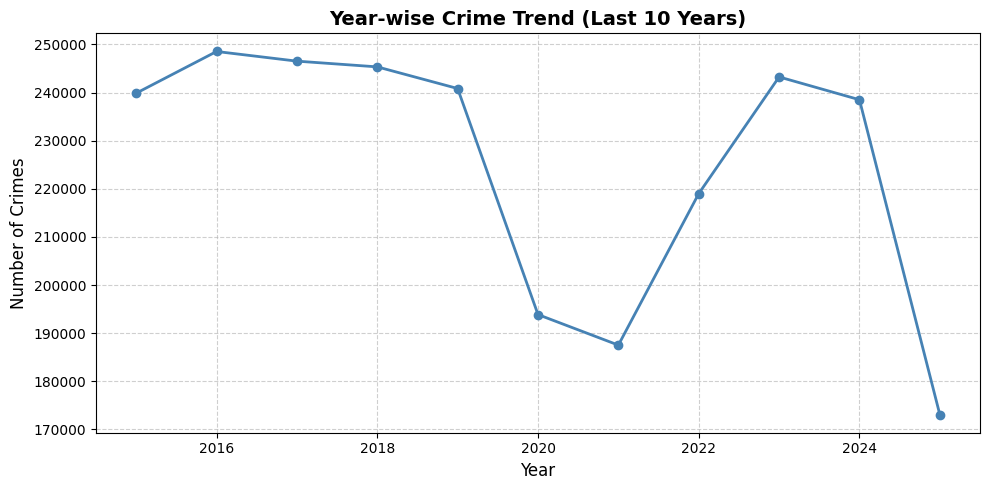

In [36]:
import matplotlib.pyplot as plt
# Converting to Pandas DataFrame for plotting
year_df = yearly_trend.toPandas()
fig, ax = plt.subplots(figsize=(10, 5))
# Plotting the line with markers
ax.plot(
    year_df["Year"],
    year_df["count"],
    marker='o',
    linestyle='-',
    color='steelblue',
    linewidth=2,
    markersize=6
)
# Setting the  titles and labels
ax.set_title("Year-wise Crime Trend (Last 10 Years)", fontsize=14, fontweight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of Crimes", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#Visualizing the data
plt.show()


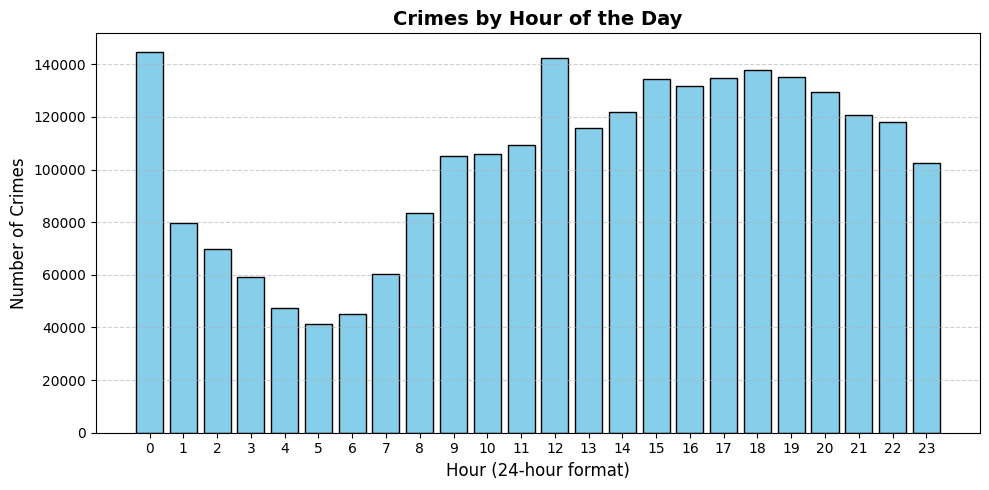

In [37]:
#Crimes by Hour of the Day
hour_df = hourly_trend.toPandas()
fig, ax = plt.subplots(figsize=(10, 5))
# Plotting a bar chart graph
ax.bar(
    hour_df["Hour"],
    hour_df["count"],
    color='skyblue',
    edgecolor='black'
)
ax.set_title("Crimes by Hour of the Day", fontsize=14, fontweight='bold')
ax.set_xlabel("Hour (24-hour format)", fontsize=12)
ax.set_ylabel("Number of Crimes", fontsize=12)
ax.set_xticks(np.arange(0, 24, 1))
ax.set_xticklabels(np.arange(0, 24, 1), rotation=0)
# Add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

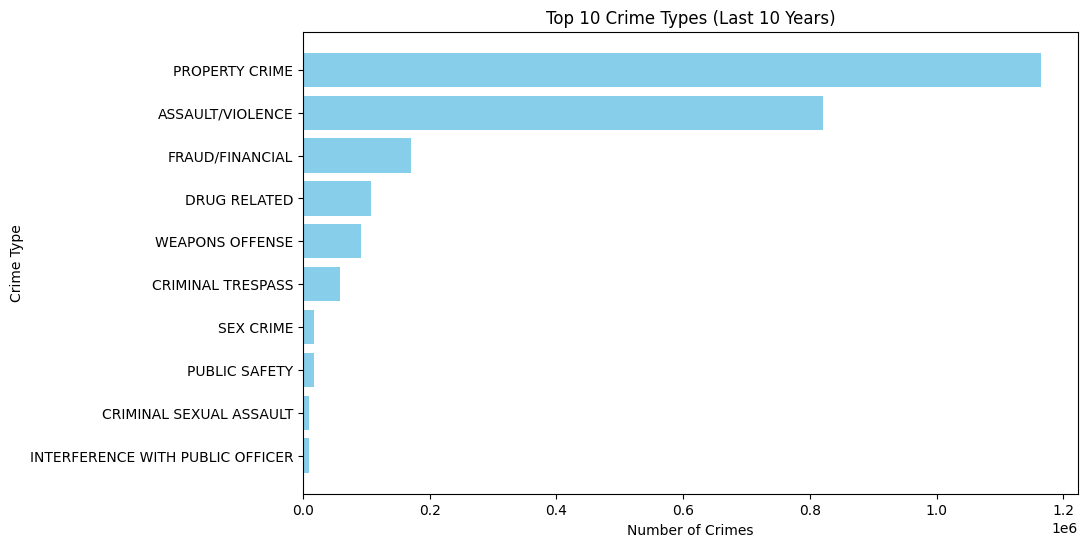

In [38]:
# Top 10 Crime Types
top_pd = top_crimes.toPandas()
plt.figure(figsize=(10,6))
plt.barh(top_pd["Primary Type"], top_pd["count"], color='skyblue')
plt.title("Top 10 Crime Types (Last 10 Years)")
plt.xlabel("Number of Crimes")
plt.ylabel("Crime Type")
plt.gca().invert_yaxis()
plt.show()